In [75]:
import numpy as np
import seaborn as sns
import torch
import random
import pathlib
import os
import glob
import scipy
import cv2
import math
from matplotlib import pyplot as plt
import pandas as pd
from skimage.transform import resize
import tqdm
import torch.nn.functional as F

from skimage.filters import gaussian
from skimage.morphology import label as connected_components

## Data Preparation

In [2]:
def _prepare_patching(img,channel, window_size, mask_size, return_src_top_corner=False):
    """Prepare patch information for tile processing.
    Args:
        img: original input image
        window_size: input patch size
        mask_size: output patch size
        return_src_top_corner: whether to return coordiante information for top left corner of img
        
    """
    win_size = window_size
    msk_size = step_size = mask_size

    def get_last_steps(length, msk_size, step_size):
        nr_step = math.ceil((length - msk_size) / step_size)
        last_step = (nr_step + 1) * step_size
        return int(last_step), int(nr_step + 1)

    im_h = img.shape[0]
    im_w = img.shape[1]

    last_h, _ = get_last_steps(im_h, msk_size, step_size)
    last_w, _ = get_last_steps(im_w, msk_size, step_size)

    diff = win_size - step_size
    padt = padl = diff // 2
    padb = last_h + win_size - im_h
    padr = last_w + win_size - im_w
    if channel==3:
        img = np.lib.pad(img, ((padt, padb), (padl, padr), (0, 0)), "reflect")
    else:
        img = np.lib.pad(img, ((padt, padb), (padl, padr)), "reflect")


    # generating subpatches index from orginal
    coord_y = np.arange(0, last_h, step_size, dtype=np.int32)
    coord_x = np.arange(0, last_w, step_size, dtype=np.int32)
    row_idx = np.arange(0, coord_y.shape[0], dtype=np.int32)
    col_idx = np.arange(0, coord_x.shape[0], dtype=np.int32)
    coord_y, coord_x = np.meshgrid(coord_y, coord_x)
    row_idx, col_idx = np.meshgrid(row_idx, col_idx)
    coord_y = coord_y.flatten()
    coord_x = coord_x.flatten()
    row_idx = row_idx.flatten()
    col_idx = col_idx.flatten()

    patch_info = np.stack([coord_y, coord_x, row_idx, col_idx], axis=-1)
    if not return_src_top_corner:
        return img,patch_info
    else:
        return img, patch_info, [padt, padl]

In [3]:
def fix_randomness(seed=0):
    np.random.seed(seed=seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)

In [4]:
import scipy.io
labels_path = glob.glob('/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Labels/**.mat')
labels_path.sort()
comb_path = glob.glob('/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/pred_trained_CoNSep/**.mat')
comb_path.sort()
dict_pred = scipy.io.loadmat(comb_path[0])
dict_pred.keys(),dict_pred['nuc_pred'].shape

(dict_keys(['__header__', '__version__', '__globals__', 'class_output', 'grad_map', 'nuc_pred', 'raw_map']),
 (1000, 1000, 1))

In [5]:
def return_patch(img_,channel, window_size, mask_size,counter,patch_img_accum=None):
    img, patch_info_list= _prepare_patching(img_,channel=channel, \
                                            window_size = window_size, mask_size = mask_size)

    for i in range(len(patch_info_list)):

        patch_img = img[
            patch_info_list[i][0] : patch_info_list[i][0] + window_size,
            patch_info_list[i][1] : patch_info_list[i][1] + window_size,
        ]


        if counter==0:
            patch_img_accum = torch.tensor(patch_img).unsqueeze(dim=0)

            counter +=1

        else:
            patch_img_accum = torch.cat((patch_img_accum,torch.tensor(patch_img).unsqueeze(dim=0)),dim=0)

            counter +=1
    return patch_img_accum, counter

In [6]:
# comb_path

In [81]:
for indx,(label_files,comb_files) in enumerate(zip(labels_path,comb_path)):
    dict_comb = scipy.io.loadmat(comb_files)
    dict_gt = scipy.io.loadmat(label_files)
#     if indx==6:
#         break
#     input_ = dict_comb['class_output'][:,:,6]


# plt.imshow(dict_comb['raw_map'])
# plt.colorbar()
# # dict_comb.keys()
comb_files

'/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/pred_trained_CoNSep/test_9.mat'

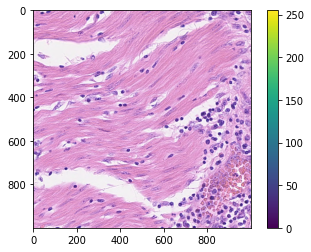

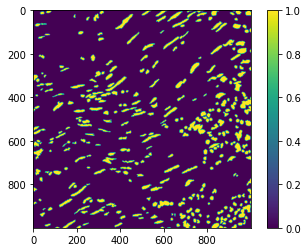

In [82]:
plt.imshow(dict_comb['raw_map'])
plt.colorbar()
plt.figure()
# dict_comb['class_output'][:,:,6]
plt.imshow(dict_gt['inst_map']>0)
plt.colorbar()

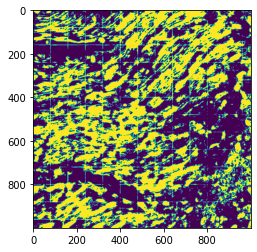

In [105]:
plt.imshow((dict_comb['class_output'][:,:,6])>0.00001)

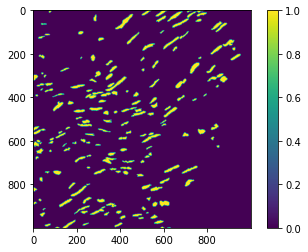

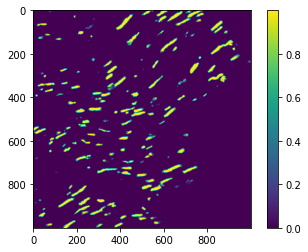

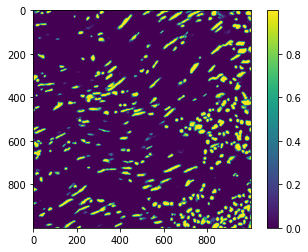

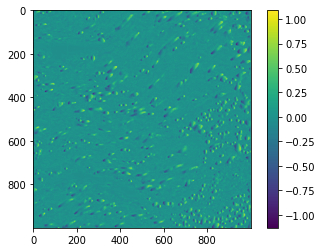

In [100]:
# dict_comb['class_output'][:,:,6]
plt.imshow(dict_gt['type_map']==6)
plt.colorbar()
plt.figure()
plt.imshow(dict_comb['class_output'][:,:,6])
plt.colorbar()
plt.figure()
plt.imshow(dict_comb['grad_map'][:,:,0])
plt.colorbar()
plt.figure()
plt.imshow(dict_comb['grad_map'][:,:,1])
plt.colorbar()

In [7]:
window_size = 164
mask_size = 164
labels_path = glob.glob('/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Labels/**.mat')
labels_path.sort()
comb_path = glob.glob('/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/pred_trained_CoNSep/**.mat')
comb_path.sort()
pbar = tqdm.tqdm(
                desc="Processing Patches",
                leave=True,
                total=int(len(labels_path)), #*(math.ceil(1000/window_size)**2
                ncols=80,
                ascii=True,
                position=0,
            )
counter_gt_inst_type = 0
counter_pred_inst_type = 0
for indx,(label_files,comb_files) in enumerate(zip(labels_path,comb_path)):
    dict_comb = scipy.io.loadmat(comb_files)
    dict_gt = scipy.io.loadmat(label_files)
    
    input_ = dict_comb['grad_map'][:,:,0]
    channel_ = 1
    if counter_pred_inst_type == 0:
        patch_pred_inst_type,counter_pred_inst_type = return_patch(input_,channel=channel_, \
                                               window_size=window_size, mask_size=mask_size,\
                                                               counter=counter_pred_inst_type\
                                                               ) 
    else:
        patch_pred_inst_type,counter_pred_inst_type = return_patch(input_,channel=channel_, \
                                               window_size=window_size, mask_size=mask_size,\
                                                               counter=counter_pred_inst_type,\
                                                               patch_img_accum=patch_pred_inst_type) 
        
        
    input_ = dict_gt['inst_map']>0
    
    channel_ = 1
    if counter_gt_inst_type == 0:
        patch_gt_inst_type,counter_gt_inst_type = return_patch(input_,channel=channel_, \
                                               window_size=window_size, mask_size=mask_size,\
                                                               counter=counter_gt_inst_type\
                                                               ) 
    else:
        patch_gt_inst_type,counter_gt_inst_type = return_patch(input_,channel=channel_, \
                                               window_size=window_size, mask_size=mask_size,\
                                                               counter=counter_gt_inst_type,\
                                                               patch_img_accum=patch_gt_inst_type) 
    
              
            
    pbar.update()
pbar.close()

Processing Patches: 100%|#######################| 14/14 [00:06<00:00,  2.15it/s]


In [8]:

for i in range(0,patch_gt_inst_type.shape[0]):
    if i==0 and (patch_gt_inst_type[i,:,:].sum())!=0:
        patch_gt_inst__= patch_gt_inst_type[i,:,:].unsqueeze(dim=0)
        patch_pred_inst__= patch_pred_inst_type[i,:,:].unsqueeze(dim=0)
#         print(patch_pred_inst__.shape)
    elif (patch_gt_inst_type[i,:,:].sum())!=0:
        patch_gt_inst__ = torch.cat((patch_gt_inst__,patch_gt_inst_type[i,:,:].unsqueeze(dim=0)),dim=0)
        patch_pred_inst__ = torch.cat((patch_pred_inst__,patch_pred_inst_type[i,:,:].unsqueeze(dim=0)),dim=0)
        
        
# patch_gt_inst__ = np.array(patch_gt_inst__)
# patch_pred_inst__ = 

# patch_pred_inst__.shape

In [96]:
torch.tensor(patch_gt_inst__)

TypeError: only integer tensors of a single element can be converted to an index

In [16]:
# plt.imshow(patch_gt_inst_type[100])
# plt.colorbar()
# plt.figure()
# plt.imshow(patch_pred_inst_type[100])
# plt.colorbar()

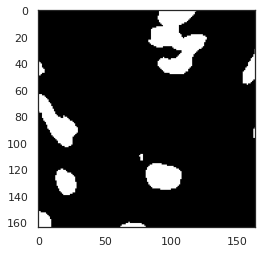

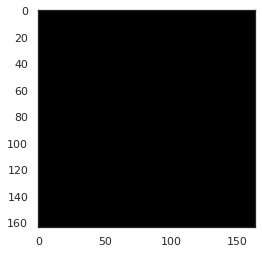

In [262]:
plt.imshow(T[100],cmap='gray')
# plt.colorbar()
plt.figure()
plt.imshow(results_perpolyp[10],cmap='gray')
# plt.colorbar()

In [305]:
T = (regions >= (0.8))

In [306]:
# T = (regions >= (-lambdas_example_table[200]))

num_polyps = masks.max(dim=1)[0].max(dim=1)[0]

False_pos = (T.to(int) - (masks>0).to(int))
F.relu(False_pos, inplace=True) 
# False_pos = False_pos * masks
results_perpolyp = torch.zeros((num_polyps.sum().int().item(), \
                                masks.shape[1], masks.shape[2]))
#     print("num_polyps",num_polyps.sum().int().item())
masks_perpolyp = torch.zeros_like(results_perpolyp)
# results_perpolyp.shape
k = 0
for n in range(num_polyps.max().int().item()):
    filter_bool = (num_polyps >= n + 1) # 1, 2, 3 polyps 
    temp_False_pos = False_pos[filter_bool]
    temp_masks = masks[filter_bool]
    results_perpolyp[k:k+temp_False_pos.shape[0]] = (temp_False_pos == n + 1)
    masks_perpolyp[k:k+temp_False_pos.shape[0]] = (temp_masks == n+1)
    k += temp_False_pos.shape[0] 
results_perpolyp = results_perpolyp.to(float).sum(dim=1).sum(dim=1)/((164*164) - masks_perpolyp.sum(dim=1).sum(dim=1))

In [307]:
(results_perpolyp).mean()

tensor(0.0352, dtype=torch.float64)

In [304]:
(results_perpolyp).mean()

tensor(0.0421, dtype=torch.float64)

In [301]:
# masks_perpolyp.sum(dim=1).sum(dim=1)
# (164*164) - (masks_perpolyp.sum(dim=1).sum(dim=1))
(results_perpolyp).mean()

tensor(0.0541, dtype=torch.float64)

## Conformal

In [38]:
def loss_False_Pos(T, risk_mass, masks): # lambda in [-1,0]
    # Get the missed pixels 
    num_polyps = masks.max(dim=1)[0].max(dim=1)[0]

    False_pos = (T.to(int) - (masks>0).to(int))
    F.relu(False_pos, inplace=True) 
    # False_pos = False_pos * masks
    results_perpolyp = torch.zeros((num_polyps.sum().int().item(), \
                                    masks.shape[1], masks.shape[2]))
    #     print("num_polyps",num_polyps.sum().int().item())
    masks_perpolyp = torch.zeros_like(results_perpolyp)
    # results_perpolyp.shape
    k = 0
    for n in range(num_polyps.max().int().item()):
        filter_bool = (num_polyps >= n + 1) # 1, 2, 3 polyps 
        temp_False_pos = False_pos[filter_bool]
        temp_masks = masks[filter_bool]
        results_perpolyp[k:k+temp_False_pos.shape[0]] = (temp_False_pos == n + 1)
        masks_perpolyp[k:k+temp_False_pos.shape[0]] = (temp_masks == n+1)
        k += temp_False_pos.shape[0] 
    results_perpolyp = results_perpolyp.to(float).sum(dim=1).sum(dim=1)/((164*164) - masks_perpolyp.sum(dim=1).sum(dim=1))
    return results_perpolyp

In [39]:
def get_example_loss_and_size_tables_False_Pos(regions, masks, lambdas_example_table, num_calib):
    lam_len = len(lambdas_example_table)
    lam_low = min(lambdas_example_table)
    lam_high = max(lambdas_example_table)
    fname_loss = f'.cache_trained/{lam_low}_{lam_high}_{lam_len}_example_loss_table.npy'
    fname_sizes = f'.cache_trained/{lam_low}_{lam_high}_{lam_len}_example_size_table.npy'
    try:
        loss_table = np.load(fname_loss)
        sizes_table = np.load(fname_sizes)
    except:
        print("computing loss and size table")
        loss_table = np.zeros((regions.shape[0], lam_len))
        sizes_table = np.zeros((regions.shape[0], lam_len))
#         print(loss_table.shape,sizes_table.shape)
        for j in tqdm.tqdm(range(lam_len)):
            est_regions = (regions >= -lambdas_example_table[j])
#             print("loss_False_Neg",loss_False_Neg(est_regions, regions, masks).shape)
#             print("loss_table[:,j] ",loss_table[:,j].shape)
            loss_table[:,j] = loss_False_Pos(est_regions, regions, masks) 
            sizes_table[:,j] = est_regions.sum(dim=1).sum(dim=1)/((164*164) - masks.sum(dim=1).sum(dim=1))

        np.save(fname_loss, loss_table)
        np.save(fname_sizes, sizes_table)


        return loss_table, sizes_table
# example_loss_table, example_sizes_table = get_example_loss_and_size_tables(regions, masks, \
#                                                                                    lambdas_example_table, \
#                                                                                    num_calib)

In [9]:
def loss_False_Neg(T, risk_mass, masks): # lambda in [-1,0]
    # Get the missed pixels 
    num_polyps = masks.max(dim=1)[0].max(dim=1)[0]
    
    missed = ((masks>0).to(int) - T.to(int)) # as lambda grows, the sets grow.
    F.relu(missed, inplace=True) 
    # Split the different polyps into different rows.
    missed = missed * masks
    results_perpolyp = torch.zeros((num_polyps.sum().int().item(), \
                                    masks.shape[1], masks.shape[2]))
#     print("num_polyps",num_polyps.sum().int().item())
    masks_perpolyp = torch.zeros_like(results_perpolyp)
    k = 0
    for n in range(num_polyps.max().int().item()):
        filter_bool = (num_polyps >= n + 1) # 1, 2, 3 polyps 
        temp_missed = missed[filter_bool]
        temp_masks = masks[filter_bool]
        results_perpolyp[k:k+temp_missed.shape[0]] = (temp_missed == n + 1)
        masks_perpolyp[k:k+temp_missed.shape[0]] = (temp_masks == n+1)
        k += temp_missed.shape[0] 
    results_perpolyp = results_perpolyp.to(float).sum(dim=1).sum(dim=1)/masks_perpolyp.sum(dim=1).sum(dim=1)    
    return results_perpolyp

In [10]:
def get_example_loss_and_size_tables(regions, masks, lambdas_example_table, num_calib):
    lam_len = len(lambdas_example_table)
    lam_low = min(lambdas_example_table)
    lam_high = max(lambdas_example_table)
    fname_loss = f'.cache_trained/{lam_low}_{lam_high}_{lam_len}_example_loss_table.npy'
    fname_sizes = f'.cache_trained/{lam_low}_{lam_high}_{lam_len}_example_size_table.npy'
    try:
        loss_table = np.load(fname_loss)
        sizes_table = np.load(fname_sizes)
    except:
        print("computing loss and size table")
        loss_table = np.zeros((regions.shape[0], lam_len))
        sizes_table = np.zeros((regions.shape[0], lam_len))
#         print(loss_table.shape,sizes_table.shape)
        for j in tqdm.tqdm(range(lam_len)):
            est_regions = (regions >= -lambdas_example_table[j])
#             print("loss_False_Neg",loss_False_Neg(est_regions, regions, masks).shape)
#             print("loss_table[:,j] ",loss_table[:,j].shape)
            loss_table[:,j] = loss_False_Neg(est_regions, regions, masks) 
            sizes_table[:,j] = est_regions.sum(dim=1).sum(dim=1)/masks.sum(dim=1).sum(dim=1)

        np.save(fname_loss, loss_table)
        np.save(fname_sizes, sizes_table)


        return loss_table, sizes_table
# example_loss_table, example_sizes_table = get_example_loss_and_size_tables(regions, masks, \
#                                                                                    lambdas_example_table, \
#                                                                                    num_calib)

In [11]:
def trial_precomputed(example_loss_table, example_size_table, alpha, num_calib, num_lam, lambdas_example_table):
    total=example_loss_table.shape[0]
    perm = torch.randperm(example_loss_table.shape[0])
    example_loss_table = example_loss_table[perm]
    example_size_table = example_size_table[perm]
    calib_losses, val_losses = (example_loss_table[0:num_calib], example_loss_table[num_calib:])
    calib_sizes, val_sizes = (example_size_table[0:num_calib], example_size_table[num_calib:])

    lhat = get_lhat(calib_losses[:,::-1], lambdas_example_table[::-1], alpha)

    losses = val_losses[:,np.argmax(lambdas_example_table == lhat)]
    #print(lhat,losses)
    size = np.random.choice(val_sizes[:,np.argmax(lambdas_example_table == lhat)])

    return lhat, losses.mean(), size

In [55]:
def get_lhat(calib_loss_table, lambdas, alpha, B=1):
    n = calib_loss_table.shape[0]
    rhat = calib_loss_table.mean(axis=0)
#     print()

    lhat_idx = max(np.argmax(((n/(n+1)) * rhat + B/(n+1)) >= alpha) - 1, 0) # Can't be -1.
    #print(lhat_idx, lambdas[lhat_idx])
    return lambdas[lhat_idx]



In [13]:
def plot_histograms(df, alpha, output_dir):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
    axs[0].hist(df['risk'].to_numpy(), alpha=0.7, density=True)

    normalized_size = df['sizes'].to_numpy()
    axs[1].hist(normalized_size, bins=60, alpha=0.7, density=True)

    axs[0].set_xlabel('risk')
    axs[0].locator_params(axis='x', nbins=10)
    axs[0].axvline(x=alpha,c='#999999',linestyle='--',alpha=0.7)
    axs[0].set_ylabel('density')
    axs[1].set_xlabel('set size as a fraction of polyp size')
    axs[1].locator_params(axis='x', nbins=10)
    axs[1].set_yscale('log')
    #axs[1].legend()
    sns.despine(top=True, right=True, ax=axs[0])
    sns.despine(top=True, right=True, ax=axs[1])
    plt.tight_layout()
    plt.savefig( output_dir + (f'{alpha}_polyp_histograms').replace('.','_') + '.pdf'  )
    print(f"The mean and standard deviation of the risk over {len(df)} trials are {df['risk'].mean()} and {df['risk'].std()} respectively.")

In [40]:
import shutil
# shutil.rmtree(cache_path)
# patch_gt_inst__.shape
shutil.rmtree('./.cache_trained/')

In [41]:
with torch.no_grad():
        sns.set(palette='pastel', font='serif')
        sns.set_style('white')
        fix_randomness()

        cache_path = './.cache_trained/'
        output_dir = 'outputs/histograms/'
        pathlib.Path(cache_path).mkdir(parents=True, exist_ok=True)
        pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

        num_trials = len(patch_gt_inst__)
        num_calib = 500
        num_lam = 500
        alpha = 0.03
        lambdas_example_table = np.linspace(-1,0,500)
        masks = patch_gt_inst__
        regions = patch_pred_inst__
        # num_components = get_data(cache_path)
        masks[masks > 1] = 1
#         df = experiment(patch_gt_inst__, patch_gt_inst__, alpha, num_trials, \
#                         num_calib, num_lam, output_dir, lambdas_example_table)



        fname = cache_path +'/'+ f'{alpha}_{num_calib}_{num_lam}_dataframe'.replace('.','_') + '.pkl'
    #     os.makedirs(fname, exist_ok=True)

        df = pd.DataFrame(columns=['$\\hat{\\lambda}$','risk','sizes','alpha'])
    #     try:
    #         print('Dataframe loaded')
    #         df = pd.read_pickle(fname)
    #     except:
        example_loss_table_FP, example_sizes_table_FP = get_example_loss_and_size_tables_False_Pos(regions, masks, \
                                                                                   lambdas_example_table, \
                                                                                   num_calib)

#         local_df_list = []
#         for i in tqdm.tqdm(range(num_trials)):
#             lhat, risk, sizes = \
#             trial_precomputed(example_loss_table, example_sizes_table, alpha, num_calib, num_lam, lambdas_example_table)
# #             print("lhat",lhat)
#             dict_local = {"$\\hat{\\lambda}$": lhat, "risk": risk, "sizes": sizes, "alpha": alpha}
#             df_local = pd.DataFrame(dict_local, index=[i])
#             local_df_list = local_df_list + [df_local]
#         df = pd.concat(local_df_list, axis=0, ignore_index=True)
#         df.to_pickle(fname)
#         plot_histograms(df, alpha, output_dir)


computing loss and size table


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [02:56<00:00,  2.83it/s]


computing loss and size table


100%|████████████████████████████████████████████████████████████████████████████████| 654/654 [00:00<00:00, 736.67it/s]


The mean and standard deviation of the risk over 654 trials are 0.04778028364407875 and 0.007966967581959165 respectively.


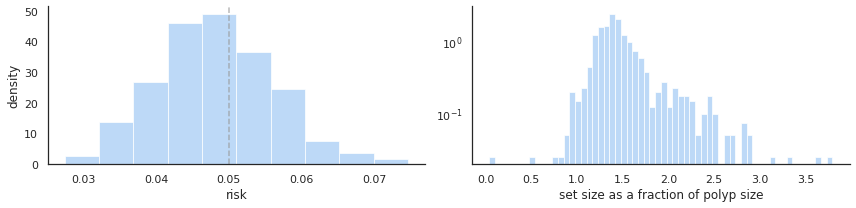

In [17]:
with torch.no_grad():
        sns.set(palette='pastel', font='serif')
        sns.set_style('white')
        fix_randomness()

        cache_path = './.cache_trained/'
        output_dir = 'outputs/histograms/'
        pathlib.Path(cache_path).mkdir(parents=True, exist_ok=True)
        pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

        num_trials = len(patch_gt_inst__)
        num_calib = 500
        num_lam = 500
        alpha = 0.05
        lambdas_example_table = np.linspace(-1,0,500)
        masks = patch_gt_inst__
        regions = patch_pred_inst__
        # num_components = get_data(cache_path)
        masks[masks > 1] = 1
#         df = experiment(patch_gt_inst__, patch_gt_inst__, alpha, num_trials, \
#                         num_calib, num_lam, output_dir, lambdas_example_table)



        fname = cache_path +'/'+ f'{alpha}_{num_calib}_{num_lam}_dataframe'.replace('.','_') + '.pkl'
    #     os.makedirs(fname, exist_ok=True)

        df = pd.DataFrame(columns=['$\\hat{\\lambda}$','risk','sizes','alpha'])
    #     try:
    #         print('Dataframe loaded')
    #         df = pd.read_pickle(fname)
    #     except:
        example_loss_table, example_sizes_table = get_example_loss_and_size_tables(regions, masks, \
                                                                                   lambdas_example_table, \
                                                                                   num_calib)

        local_df_list = []
        for i in tqdm.tqdm(range(num_trials)):
            lhat, risk, sizes = \
            trial_precomputed(example_loss_table, example_sizes_table, alpha, num_calib, num_lam, lambdas_example_table)
#             print("lhat",lhat)
            dict_local = {"$\\hat{\\lambda}$": lhat, "risk": risk, "sizes": sizes, "alpha": alpha}
            df_local = pd.DataFrame(dict_local, index=[i])
            local_df_list = local_df_list + [df_local]
        df = pd.concat(local_df_list, axis=0, ignore_index=True)
        df.to_pickle(fname)
        plot_histograms(df, alpha, output_dir)


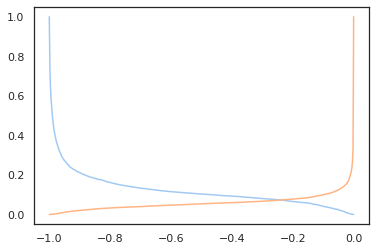

In [43]:
plt.plot(lambdas_example_table,example_loss_table[0])
plt.plot(lambdas_example_table,example_loss_table_FP[0])
# example_loss_table.shape
# lambdas_example_table.shape

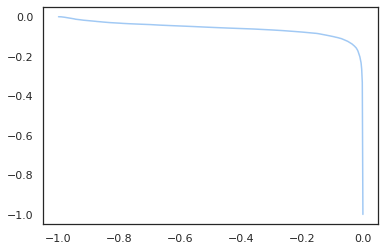

In [44]:
plt.plot(lambdas_example_table,-example_loss_table_FP[0])

In [59]:
def get_lhat_FP(calib_loss_table, lambdas, alpha, B=1):
    n = calib_loss_table.shape[0]
    rhat = calib_loss_table.mean(axis=0)
#     print()

    lhat_idx = max(np.argmax(((n/(n+1)) * rhat + B/(n+1)) <= alpha) - 1, 0) # Can't be -1.
    #print(lhat_idx, lambdas[lhat_idx])
    return lambdas[lhat_idx]

In [60]:
def trial_precomputed(example_loss_table, example_size_table, alpha, num_calib, num_lam, lambdas_example_table):
    total=example_loss_table.shape[0]
    perm = torch.randperm(example_loss_table.shape[0])
    example_loss_table = example_loss_table[perm]
    example_size_table = example_size_table[perm]
    calib_losses, val_losses = (example_loss_table[0:num_calib], example_loss_table[num_calib:])
    calib_sizes, val_sizes = (example_size_table[0:num_calib], example_size_table[num_calib:])

    lhat = get_lhat_FP(calib_losses[:,::-1], lambdas_example_table[::-1], alpha,0)

    losses = val_losses[:,np.argmax(lambdas_example_table == lhat)]
    #print(lhat,losses)
    size = np.random.choice(val_sizes[:,np.argmax(lambdas_example_table == lhat)])

    return lhat, losses.mean(), size

100%|████████████████████████████████████████████████████████████████████████████████| 654/654 [00:00<00:00, 775.02it/s]


The mean and standard deviation of the risk over 654 trials are 0.030121072659072122 and 0.002867127624119622 respectively.


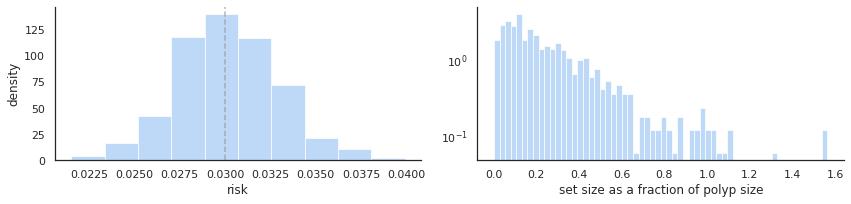

In [61]:
local_df_list = []
for i in tqdm.tqdm(range(num_trials)):
    lhat, risk, sizes = \
    trial_precomputed(example_loss_table_FP, example_sizes_table_FP, alpha, num_calib, num_lam, lambdas_example_table)
#             print("lhat",lhat)
    dict_local = {"$\\hat{\\lambda}$": lhat, "risk": risk, "sizes": sizes, "alpha": alpha}
    df_local = pd.DataFrame(dict_local, index=[i])
    local_df_list = local_df_list + [df_local]
df = pd.concat(local_df_list, axis=0, ignore_index=True)
df.to_pickle(fname)
plot_histograms(df, alpha, output_dir)

In [74]:
lhat

-0.8557114228456915

(array([ 1.,  0.,  4.,  0.,  0.,  6.,  0.,  0., 14.,  0.,  0., 17.,  0.,
         0., 34.,  0.,  0., 64.,  0.,  0., 73.,  0., 83.,  0.,  0., 73.,
         0.,  0., 57.,  0.,  0., 72.,  0.,  0., 50.,  0.,  0., 42.,  0.,
        25.,  0.,  0., 10.,  0.,  0., 13.,  0.,  0.,  8.,  0.,  0.,  3.,
         0.,  0.,  3.,  0.,  0.,  0.,  0.,  2.]),
 array([-0.8757515 , -0.8750501 , -0.8743487 , -0.87364729, -0.87294589,
        -0.87224449, -0.87154309, -0.87084168, -0.87014028, -0.86943888,
        -0.86873747, -0.86803607, -0.86733467, -0.86663327, -0.86593186,
        -0.86523046, -0.86452906, -0.86382766, -0.86312625, -0.86242485,
        -0.86172345, -0.86102204, -0.86032064, -0.85961924, -0.85891784,
        -0.85821643, -0.85751503, -0.85681363, -0.85611222, -0.85541082,
        -0.85470942, -0.85400802, -0.85330661, -0.85260521, -0.85190381,
        -0.8512024 , -0.850501  , -0.8497996 , -0.8490982 , -0.84839679,
        -0.84769539, -0.84699399, -0.84629259, -0.84559118, -0.84488978,
 

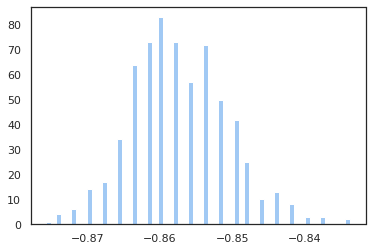

In [62]:
plt.hist(df['$\hat{\lambda}$'],bins=60)
# lhat


In [64]:
patch_gt_accum = patch_gt_inst__
patch_pred_accum = patch_pred_inst__

In [65]:
# np.unique(patch_gt_inst__[in_dex])

torch.Size([164, 164])

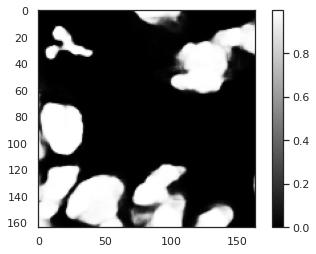

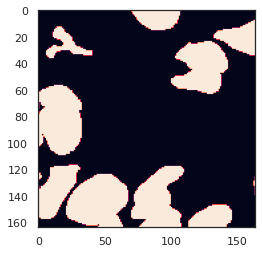

In [66]:
in_dex = 346
plt.imshow(patch_pred_accum[in_dex],cmap='gray')
plt.colorbar()
plt.figure()
plt.imshow(patch_gt_inst__[in_dex])
patch_gt_inst__[in_dex].shape

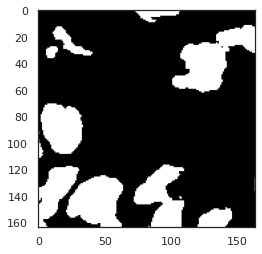

In [67]:
plt.imshow(patch_pred_accum[in_dex]>(-df['$\hat{\lambda}$'].mean()),cmap='gray')

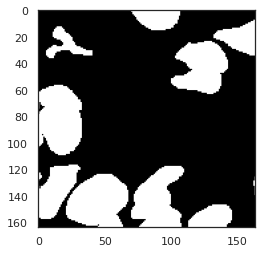

In [68]:
plt.imshow(patch_gt_accum[in_dex],cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


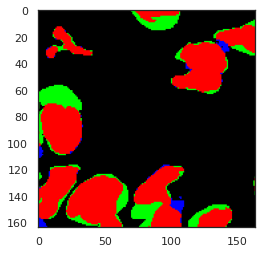

In [69]:
final_ = np.array(torch.ones(patch_gt_accum.shape[-2],patch_gt_accum.shape[-1],3))
pred = np.array(patch_pred_accum[in_dex]>(-df['$\hat{\lambda}$'].mean()))
gt_ = np.array(patch_gt_accum[in_dex]>0)
final_[:,:,0] = (pred & gt_) * 255
final_[:,:,1] = ((pred & gt_) ^ (gt_)) * 255
final_[:,:,2] = ((pred & gt_) ^ (pred)) * 255
plt.imshow(final_)
# plt.imshow()

In [70]:
metrics = lambda pred,gt_: ((pred & gt_).sum(),((pred & gt_) ^ (gt_)).sum(),\
                               ((pred & gt_) ^ (pred)).sum(), (~pred & ~gt_).sum())

In [71]:
pred = np.array(patch_pred_accum>(-df['$\hat{\lambda}$'].mean()))
gt_ = np.array(patch_gt_accum>0)
TP_FN_FP_TN=metrics(pred,gt_)
FNR = TP_FN_FP_TN[1]*100/(TP_FN_FP_TN[1]+TP_FN_FP_TN[0])
FPR = TP_FN_FP_TN[2]*100/(TP_FN_FP_TN[2]+TP_FN_FP_TN[3])
FPR,FNR

(2.7025134228588343, 21.785545836304934)

In [72]:
pred = np.array(patch_pred_accum>0.5)
gt_ = np.array(patch_gt_accum>0)
TP_FN_FP_TN=metrics(pred,gt_)
FNR = TP_FN_FP_TN[1]*100/(TP_FN_FP_TN[1]+TP_FN_FP_TN[0])
FPR = TP_FN_FP_TN[2]*100/(TP_FN_FP_TN[2]+TP_FN_FP_TN[3])
FPR,FNR

(4.851811581644337, 12.87180121081761)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


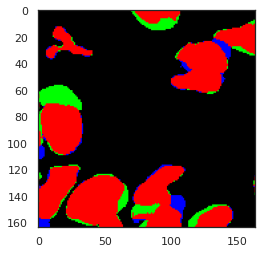

In [73]:
final_ = np.array(torch.ones(patch_gt_accum.shape[-2],patch_gt_accum.shape[-1],3))
pred = np.array(patch_pred_accum[in_dex]>0.5)
gt_ = np.array(patch_gt_accum[in_dex]>0)
final_[:,:,0] = (pred & gt_) * 255
final_[:,:,1] = ((pred & gt_) ^ (gt_)) * 255
final_[:,:,2] = ((pred & gt_) ^ (pred)) * 255
plt.imshow(final_)

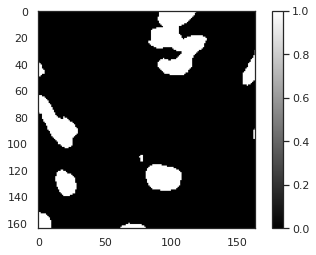

In [170]:
plt.imshow(est_regions[100,:,:],cmap='gray')
plt.colorbar()

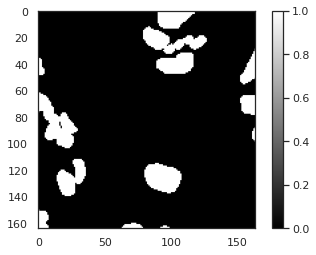

In [172]:
plt.imshow(masks[100,:,:],cmap='gray')
plt.colorbar()

In [187]:
# loss_table[0]

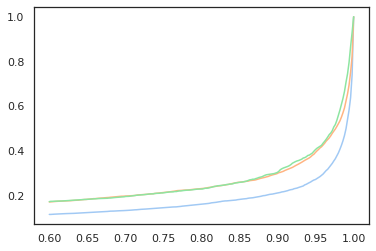

In [195]:
plt.plot(-lambdas_example_table,loss_table[0])

plt.plot(-lambdas_example_table,loss_table[10])
plt.plot(-lambdas_example_table,loss_table[20])
